# Overall Expected Outcome:

The script will retrieve historical financial data for Tesla from its 10-K filings, organize this data into a structured format (a pandas DataFrame), and then generate a series of plots to visually represent key financial trends, such as revenue growth, expense distribution, profitability (net income/loss), and margins.

## Important Considerations:

- <b>API Key</b>: Ensure your `API_KEY` is valid and has the necessary permissions. Without a correct key, the API calls will fail.
- <b>Data Availability</b>: The availability of specific financial line items (like 'Revenues', 'NetIncomeLoss') in the aggregated data depends on how they are reported in the SEC filings and parsed by the `api-bricks-sec-api-rest` library. The script includes checks to see if the required data is present before attempting to plot.
- <b>Date Parsing</b>: The script attempts to parse dates in 'm/d/y' or 'm/d/Y' format for sorting. If the dates in the period strings have a different format, the sorting might fail, and the plots might not be in chronological order. The code includes error handling for this.
- <b>API Rate Limits</b>: Be mindful of any rate limits imposed by the SEC API service you are using. Making too many requests too quickly might lead to errors.

1. Installation of API Library

This line installs the necessary Python library to interact with the SEC API.

In [1]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.7 MB/s eta 0:00:00


*Expected Result:* The `api-bricks-sec-api-rest` library will be successfully installed in your environment.

2. Import Libraries and Configuration

*Description:* This line installs the necessary Python library to interact with the SEC API.

In [2]:
# %%
# Import necessary libraries for data manipulation, API interaction, and plotting.
# 'requests' is used for making HTTP requests (though the api-bricks library handles this).
# 'pandas' is essential for working with data in a tabular format (DataFrames).
# 'matplotlib.pyplot' is used for creating visualizations.
# 'json' is for handling JSON data, which is often returned by APIs.
# 'datetime' is used for working with dates, specifically for specifying filing date ranges.
# 'api_bricks_sec_api_rest' is the core library for accessing SEC data.import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import api_bricks_sec_api_rest

# --- API Configuration ---
# Define the API key required to authenticate with the SEC API.
# **IMPORTANT:** Replace "YOUR ACTUAL KEY!" with your personal API key obtained from a service
# that provides access to the SEC API. Without a valid key, API requests will fail.
API_KEY = "YOUR_API_KEY"
# Initialize the API client object. This client will be used to make all API requests.
# The 'header_name' and 'header_value' parameters are used to pass the API key in the request header for authentication.
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Plotting Configuration ---
# Configure the plotting style for matplotlib.
# It attempts to use the 'seaborn-v0_8-darkgrid' style for better aesthetics.
# If the 'seaborn' style is not available, it falls back to the default matplotlib style and prints a warning.
try: plt.style.use('seaborn-v0_8-darkgrid')
except OSError: print("Seaborn style not found, using default."); plt.style.use('default')
# Sets the default figure size for all subsequent plots created with matplotlib, making them larger and easier to read.
plt.rcParams['figure.figsize'] = (14, 7)

*Expected Result:* All necessary libraries are imported, the API client is initialized, and the plotting style is set. You might see a warning if the 'seaborn' style is not available.

3. Retrieve SEC Filing Metadata

*Description*: This code snippet fetches metadata (like accession number, filing date, form type) for Tesla's (CIK 1318605) 10-K filings between January 1, 2015, and May 30, 2025.

In [4]:
# %%
# get filings form 10-K Tesla
# Initialize an instance of the FilingMetadataApi. This specific API client is used to retrieve
# metadata about SEC filings, such as filing date, form type, and accession number.
api_instance = api_bricks_sec_api_rest.FilingMetadataApi(api_client)
# Call the 'v1_filings_get' method of the API instance to fetch filing data.
# We are requesting filings based on the following parameters:
# - filling_date_start: Start date for the filing date range.
# - filling_date_end: End date for the filing date range.
# - page_size: The number of filings to retrieve per page (maximum results per request).
# - page_number: The specific page of results to retrieve.
# - form_type: Filters for filings of type "10-K" (Annual Report).
# - cik: Filters for filings from Tesla, identified by its Central Index Key (CIK) 1318605.
all_filings_data = api_instance.v1_filings_get (
    filling_date_start = "2015-01-01",
    filling_date_end = "2025-05-30",
    page_size = 200,
    page_number = 1,
    form_type = "10-K",
    cik = 1318605
)
# Display the raw data returned by the API. This is typically a list of objects
# representing each filing that matches the criteria.
all_filings_data

[DTOFilingMetadataDto(cik=1318605, accession_number='0001564590-19-003165', filing_date=datetime.date(2019, 2, 19), report_date=datetime.date(2018, 12, 31), acceptance_date_time=datetime.datetime(2019, 2, 19, 0, 0, tzinfo=TzInfo(UTC)), act='34', form='10-K', file_number=None, film_number='19613254', items=None, core_type=None, size=30826751, is_xbrl=True, is_inline_xbrl=False, primary_document='tsla-10k_20181231.htm', primary_doc_description='10-K', source_file='https://www.sec.gov/Archives/edgar/data/1318605/000156459019003165/tsla-10k_20181231.htm'),
 DTOFilingMetadataDto(cik=1318605, accession_number='0001564590-15-001031', filing_date=datetime.date(2015, 2, 26), report_date=datetime.date(2014, 12, 31), acceptance_date_time=datetime.datetime(2015, 2, 26, 0, 0, tzinfo=TzInfo(UTC)), act='34', form='10-K', file_number=None, film_number='15653676', items=None, core_type=None, size=20199065, is_xbrl=True, is_inline_xbrl=False, primary_document='tsla-10k_20141231.htm', primary_doc_descrip

*Expected Result*: A list of objects containing metadata for the specified 10-K filings will be retrieved from the SEC API.

4. Create and Sort Filings DataFrame

Description: The raw filing data is converted into a pandas DataFrame, keeping only the 'accession_number', 'filing_date', and 'form' columns. The DataFrame is then sorted chronologically by 'filing_date'.

In [5]:
# %%
# Convert the list of filing objects received from the API into a pandas DataFrame.
# 'pd.DataFrame.from_records' is used to create a DataFrame from a list of dictionaries or objects.
# 'vars(x)' converts each filing object 'x' into its dictionary representation.
# 'columns=['accession_number', 'filing_date']' specifies which attributes (columns) to include in the DataFrame.
df_filings = pd.DataFrame.from_records([vars(x) for x in all_filings_data], columns=['accession_number', 'filing_date'])
# Sort the DataFrame by the 'filing_date' column in ascending order. This arranges the filings chronologically.
df_filings = df_filings.sort_values(by='filing_date', ascending=True)
# Display the resulting pandas DataFrame.
df_filings

,accession_number,filing_date
1,0001564590-15-001031,2015-02-26
4,0001564590-16-013195,2016-02-24
7,0001564590-17-003118,2017-03-01
8,0001564590-18-002956,2018-02-23
0,0001564590-19-003165,2019-02-19
3,0001564590-20-004475,2020-02-13
6,0001564590-21-004599,2021-02-08
9,0000950170-22-000796,2022-02-07
2,0000950170-23-001409,2023-01-31
5,0001628280-24-002390,2024-01-29


*Expected Result*: A pandas DataFrame (`df_filings`) will be created, containing the accession number and filing date for each retrieved 10-K filing, sorted by date.

5. Define XBRL Data Retrieval Function

*Description*: This defines a function that takes an accession number and uses the `XBRLConversionApi` to retrieve the XBRL (eXtensible Business Reporting Language) data for that filing, returning it as a JSON object. It includes error handling.

In [6]:
api_xbrl_instance = api_bricks_sec_api_rest.XBRLConversionApi(api_client)

def get_xbr_json(accession_number):
  try:
    return api_xbrl_instance.v1_xbrl_converter_get(accession_no=accession_number)
  except Exception as e:
    print(f"Error processing {accession_number}: {e}")
    return None

*Expected Result*: A Python function `get_xbr_json` is defined, ready to be called for each filing.

6. Retrieve XBRL Data for All Filings

*Description*: This loop iterates through the accession numbers in the `df_filings` DataFrame and calls the get_xbr_json function for each one to retrieve the detailed XBRL financial data.

In [7]:
result = []
for accession_no in df_filings['accession_number']:
  json = get_xbr_json(accession_no)
  if json is not None:
    result.append(json)

*Expected Result*: A list (`result`) will be populated with the JSON data representing the XBRL content for each successfully retrieved 10-K filing.

7. Aggregate Financial Statement Data

*Description*: This is the core data processing step. It extracts specific financial line items (like Revenue, Net Income) from the complex XBRL structure and organizes them by reporting period.

In [35]:
aggregated_data = {}

for json_data in result:  # Iterate through each JSON in the 'result' list
      # Extract filing date to check if it's 2022 or later
      filing_year = int(json_data.get('CoverPage')['DocumentFiscalYearFocus'])

      # --- Process primary financial statements ---
      financial_statements = json_data.get('StatementConsolidatedStatementsOfOperations') or json_data.get('StatementConsolidatedStatementsOfOperations1') or json_data.get('ConsolidatedStatementsofOperations')
      if financial_statements is None:
          continue

      for statement_name, statement_values in financial_statements.items():
          # Check if the value is a list and if the list is not empty
          if isinstance(statement_values, list) and statement_values:
              # Find the first entry that does NOT contain the 'segment' key
              first_entry = None
              for entry in statement_values:
                  if isinstance(entry, dict) and 'segment' not in entry:
                      first_entry = entry
                      break # Found the entry we want, exit the inner loop

              if first_entry is not None:
                  # Check if the first element is a dictionary and contains 'value' and 'period' keys
                  if isinstance(first_entry, dict) and 'value' in first_entry and 'period' in first_entry:
                      value = first_entry['value']
                      period_data = first_entry['period'] # Change variable name to avoid confusion

                      # Check if period_data is a dictionary and contains 'endDate' key
                      if isinstance(period_data, dict) and 'endDate' in period_data:
                          period_key = period_data['startDate'] + ' - ' + period_data['endDate']
                      else:
                          # Handle case when 'period' structure is different than expected
                          print(f"Unexpected period structure for statement {statement_name}: {period_data}")
                          continue # Skip this entry and move to the next statement_name

                      if statement_name not in aggregated_data:
                          aggregated_data[statement_name] = {}

                      # Add value to the dictionary for the given statement, using period_key as column key
                      aggregated_data[statement_name][period_key] = value

      # --- Process Segment Reporting for Revenues (for filings from 2022 onwards) ---
      # We are adding this section because from 2022, Tesla started reporting consolidated Revenues
      # under the Segment Reporting section in their 10-K filings, instead of or in addition to
      # the main Statements of Operations. This ensures we capture the Revenue data for later periods.
      if filing_year is not None and filing_year >= 2022:
          segment_data = json_data.get('SegmentReportingandInformationaboutGeographicAreasScheduleofRevenuesbyGeographicAreaDetail')
          if segment_data is not None:
              revenues_entries = segment_data.get('Revenues')
              if isinstance(revenues_entries, list):

                  for entry in revenues_entries:
                      # Look for the entry that does NOT contain the 'segment' key
                      if isinstance(entry, dict) and 'segment' not in entry:
                            if isinstance(entry, dict) and 'value' in entry and 'period' in entry:
                                value = entry['value']
                                period_data = entry['period']

                                if isinstance(period_data, dict) and 'endDate' in period_data:
                                    period_key = period_data['startDate'] + ' - ' + period_data['endDate']

                                    # # Store the revenue from the segment reporting section
                                    # if 'Revenues' not in revenues_from_segments:
                                    #     revenues_from_segments['Revenues'] = {}
                                    aggregated_data['Revenues'][period_key] = value
                                else:
                                    print(f"Unexpected period structure in segment revenues: {period_data}")

      # Note: For 2016 and 2017 filings, NetIncomeLoss data appeared in this section.
      if filing_year is not None and filing_year >= 2016 and filing_year <= 2017:
          segment_data = json_data.get('StatementConsolidatedStatementsOfComprehensiveLoss')
          if segment_data is not None:
              revenues_entries = segment_data.get('NetIncomeLoss')
              if isinstance(revenues_entries, list):

                  for entry in revenues_entries:
                      # Look for the entry that does NOT contain the 'segment' key
                      if isinstance(entry, dict) and 'segment' not in entry:
                            if isinstance(entry, dict) and 'value' in entry and 'period' in entry:
                                value = entry['value']
                                period_data = entry['period']

                                if isinstance(period_data, dict) and 'endDate' in period_data:
                                    period_key = period_data['startDate'] + ' - ' + period_data['endDate']
                                    aggregated_data['NetIncomeLoss'][period_key] = value
                                    break;
                                else:
                                    print(f"Unexpected period structure in segment NetIncomeLoss: {period_data}")

# Convert aggregated data to DataFrame
df_aggregated = pd.DataFrame.from_dict(aggregated_data, orient='index')

# Display the resulting DataFrame
df_aggregated


,01/01/2014 - 12/31/2014,01/01/2015 - 12/31/2015,01/01/2016 - 12/31/2016,01/01/2017 - 12/31/2017,01/01/2018 - 12/31/2018,01/01/2019 - 12/31/2019,01/01/2020 - 12/31/2020,01/01/2021 - 12/31/2021,01/01/2022 - 12/31/2022,01/01/2023 - 12/31/2023,01/01/2024 - 12/31/2024
SalesRevenueGoodsNet,3192723000,3740973000,5589007000,8534752000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SalesRevenueServicesNet,5633000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenues,3198356000,4046025000,7000132000,11758751000,21461268000,24578000000,31536000000,53823000000,81462000000,96773000000,97690000000
CostOfGoodsSold,2310011000,2823302000,4268087000,6724480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CostOfServices,6674000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CostOfRevenue,2316685000,3122522000,5400875000,9536264000,17419247000,20509000000,24906000000,40217000000,60609000000,79113000000,80240000000
GrossProfit,881671000,923503000,1599257000,2222487000,4042021000,4069000000,6630000000,13606000000,20853000000,17660000000,17450000000
ResearchAndDevelopmentExpense,464700000,717900000,834408000,1378073000,1460370000,1343000000,1491000000,2593000000,3075000000,3969000000,4540000000
SellingGeneralAndAdministrativeExpense,603660000,922232000,1432189000,2476500000,2834491000,2646000000,3145000000,4517000000,3946000000,4800000000,5150000000
OperatingExpenses,1068360000,1640132000,2266597000,3854573000,4430094000,4138000000,4636000000,7083000000,7197000000,8769000000,10374000000


*Expected Result*: A dictionary (`aggregated_data`) will be created, where keys are financial statement line items (e.g., 'Revenues', 'NetIncomeLoss') and values are dictionaries mapping reporting periods (e.g., '01/01/2020 - 12/31/2020') to the corresponding financial value.

8. Convert Aggregated Data to DataFrame

*Description*: The aggregated dictionary is converted into a pandas DataFrame. The financial line items become the index (rows), and the reporting periods become the columns. Numeric conversion is attempted for all values.

In [36]:
# Adjust data for plotting, focusing on numerical values
for col in df_aggregated.columns:
    df_aggregated[col] = pd.to_numeric(df_aggregated[col], errors='coerce')

*Expected Result*: A pandas DataFrame (`df_aggregated`) will be created. Rows will represent financial metrics, and columns will represent the reporting periods. The values will be the extracted financial figures, converted to numeric types where possible.

## Valuable Plots Based on Available Data
The df_aggregated DataFrame contains financial statement line items as the index (rows) and reporting periods as the columns. This structure is excellent for analyzing trends over time for specific financial metrics.

Here are a few suggested plot types and the insights they can provide:

1. Line Plot of Key Revenue Metrics
A line plot is ideal for showing how key revenue figures have changed over the reporting periods.

Value: This helps visualize growth trends, seasonality, or any significant shifts in Tesla's revenue generation over time.

How to implement:

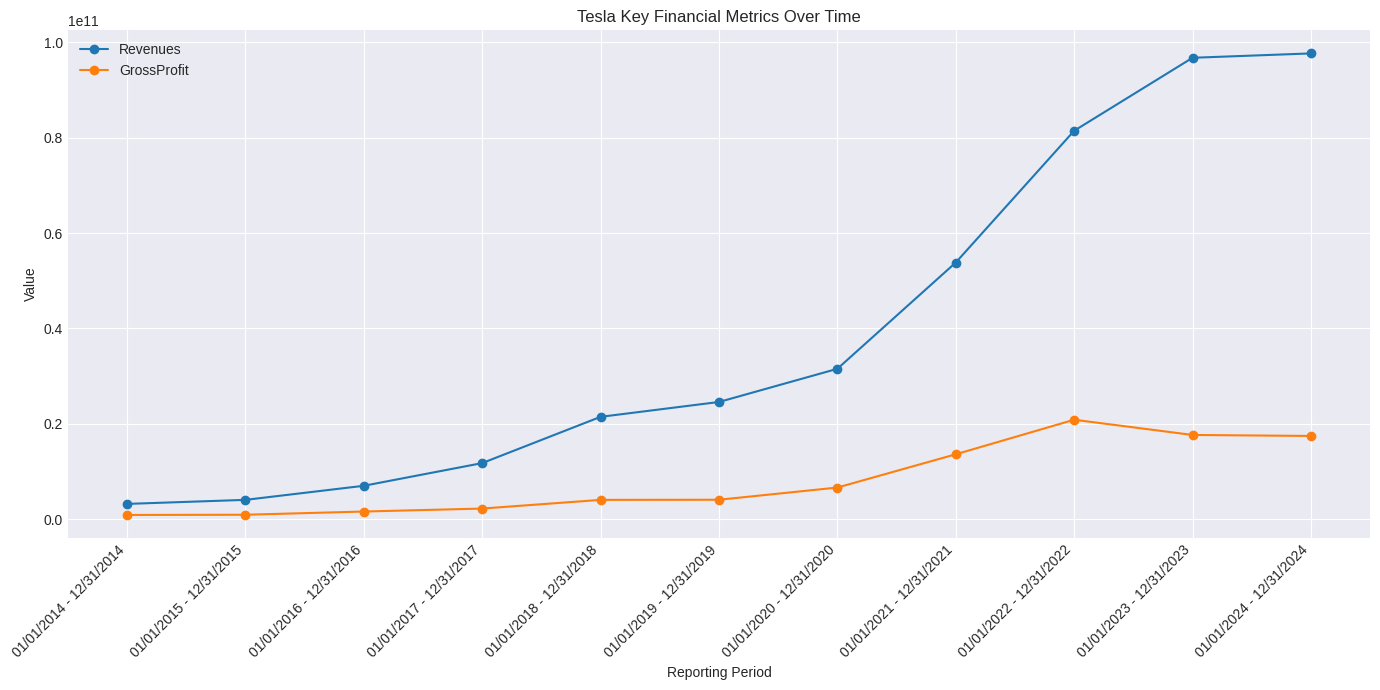

In [37]:
# Example: Plotting 'Revenues' and 'GrossProfit' if they exist
metrics_to_plot = ['Revenues', 'GrossProfit']
available_metrics = [metric for metric in metrics_to_plot if metric in df_aggregated.index]

if available_metrics:
    plt.figure(figsize=(14, 7))
    for metric in available_metrics:
        plt.plot(df_aggregated.columns, df_aggregated.loc[metric].values, marker='o', label=metric)

    plt.title('Tesla Key Financial Metrics Over Time')
    plt.xlabel('Reporting Period')
    plt.ylabel('Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    print("None of the specified metrics ('Revenues', 'GrossProfit') found in the data.")

2. Pie Chart for Tesla's Expense Breakdown
A pie chart visualization showing the distribution of different expense categories for Tesla's latest reporting period.

Value: This visualization helps understand the relative proportion of different expense categories, making it easy to identify which areas consume the largest share of Tesla's spending.

How to implement:


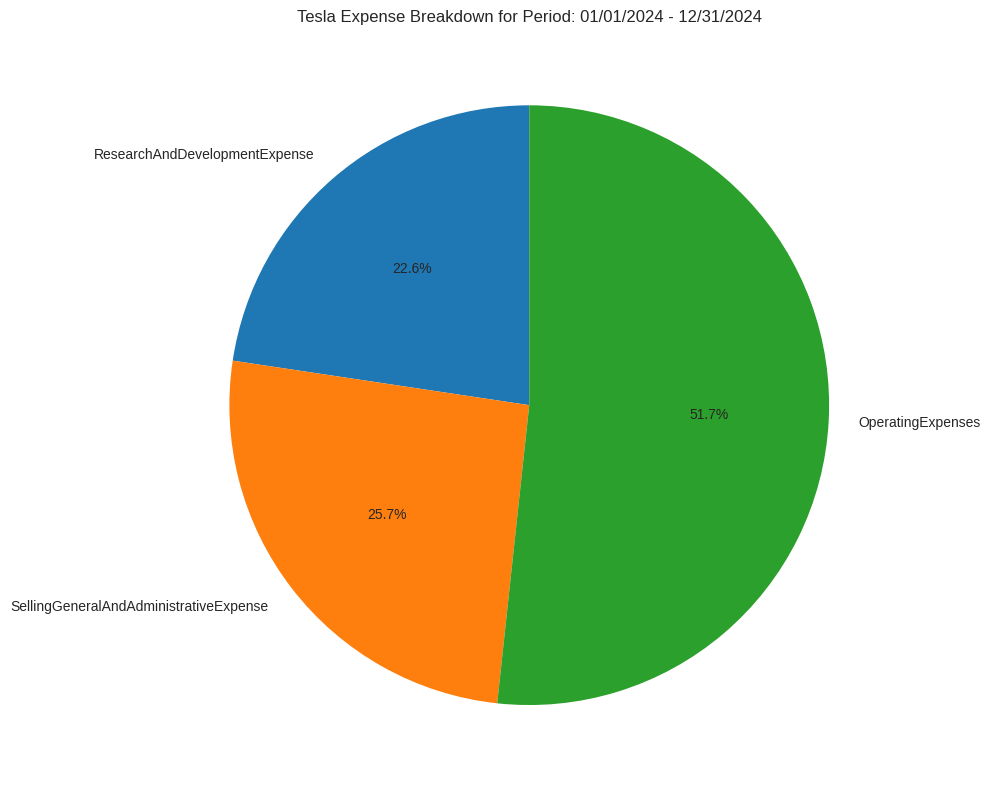

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
# Example: Plotting a breakdown of expenses for the latest period
# (Assuming 'ResearchAndDevelopmentExpense', 'SellingGeneralAndAdministrativeExpense', 'OperatingExpenses' exist)
expenses_to_plot = [
    'ResearchAndDevelopmentExpense',
    'SellingGeneralAndAdministrativeExpense',
    'OperatingExpenses'
    # Add other relevant expense line items you find in df_aggregated.index
]

# Get the latest available period
latest_period = df_aggregated.columns[-1] if len(df_aggregated.columns) > 0 else None

if latest_period:
    available_expenses_data = {
        expense: df_aggregated.loc[expense, latest_period]
        for expense in expenses_to_plot if expense in df_aggregated.index and not pd.isna(df_aggregated.loc[expense, latest_period])
    }

    if available_expenses_data:
        # Convert dictionary to a Series for easier plotting with pandas
        expense_series = pd.Series(available_expenses_data)

        plt.figure(figsize=(10, 8))
        expense_series.plot(kind='pie', autopct='%1.1f%%', startangle=90)

        plt.title(f'Tesla Expense Breakdown for Period: {latest_period}')
        plt.ylabel('') # Hide the default y-label for pie charts
        plt.tight_layout()
        plt.show()
    else:
        print(f"None of the specified expense metrics found or have data for the latest period: {latest_period}")
else:
    print("No reporting periods found in the aggregated data.")

3. Percentage Change Plot
Plotting the percentage change in a metric from period to period can highlight growth acceleration or deceleration.

Value: This provides a clearer picture of the relative growth rate, independent of the absolute values.

How to implement:

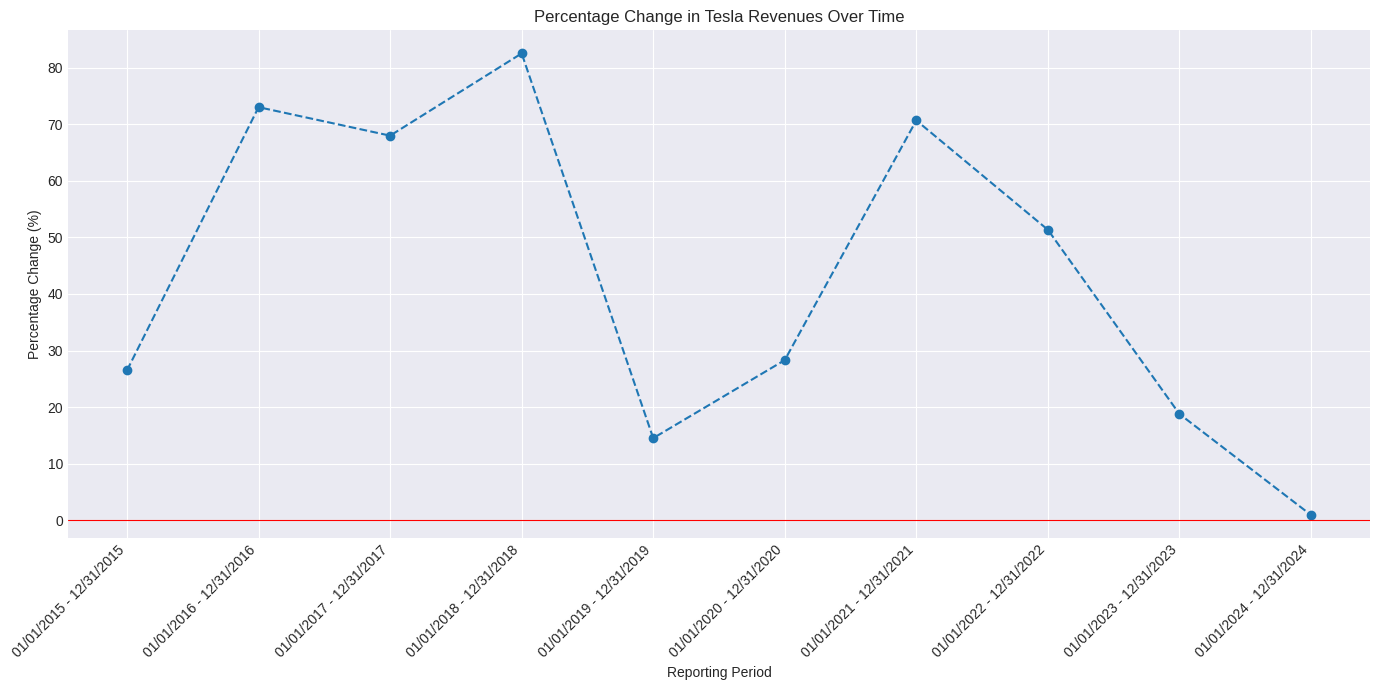

In [38]:
# Example: Plotting percentage change in 'Revenues'
if 'Revenues' in df_aggregated.index and len(df_aggregated.columns) > 1:
    revenue_data = df_aggregated.loc['Revenues']
    # Calculate the percentage change between consecutive periods
    percentage_change = revenue_data.pct_change().dropna()

    plt.figure(figsize=(14, 7))
    plt.plot(percentage_change.index, percentage_change.values * 100, marker='o', linestyle='--') # Multiply by 100 for percentage
    plt.title('Percentage Change in Tesla Revenues Over Time')
    plt.xlabel('Reporting Period')
    plt.ylabel('Percentage Change (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True)
    plt.axhline(0, color='red', linestyle='-', linewidth=0.8) # Add a horizontal line at 0 for reference
    plt.show()
elif 'Revenues' not in df_aggregated.index:
    print("'Revenues' not found in the data. Cannot plot percentage change.")
else:
    print("Not enough periods to calculate percentage change.")

4. Tesla's Net Income Trend Analysis (10-K Filings)

This line chart illustrates Tesla's net income performance over time based on their annual 10-K SEC filings. The green line represents the company's net income values, with data points marked by circles. A red dashed line at zero serves as a reference point to easily identify profitable and loss-making periods. The x-axis shows the reporting periods, while the y-axis displays the net income values. This visualization helps track Tesla's financial performance and profitability trends across different fiscal years.

Selected column for net income: NetIncomeLoss


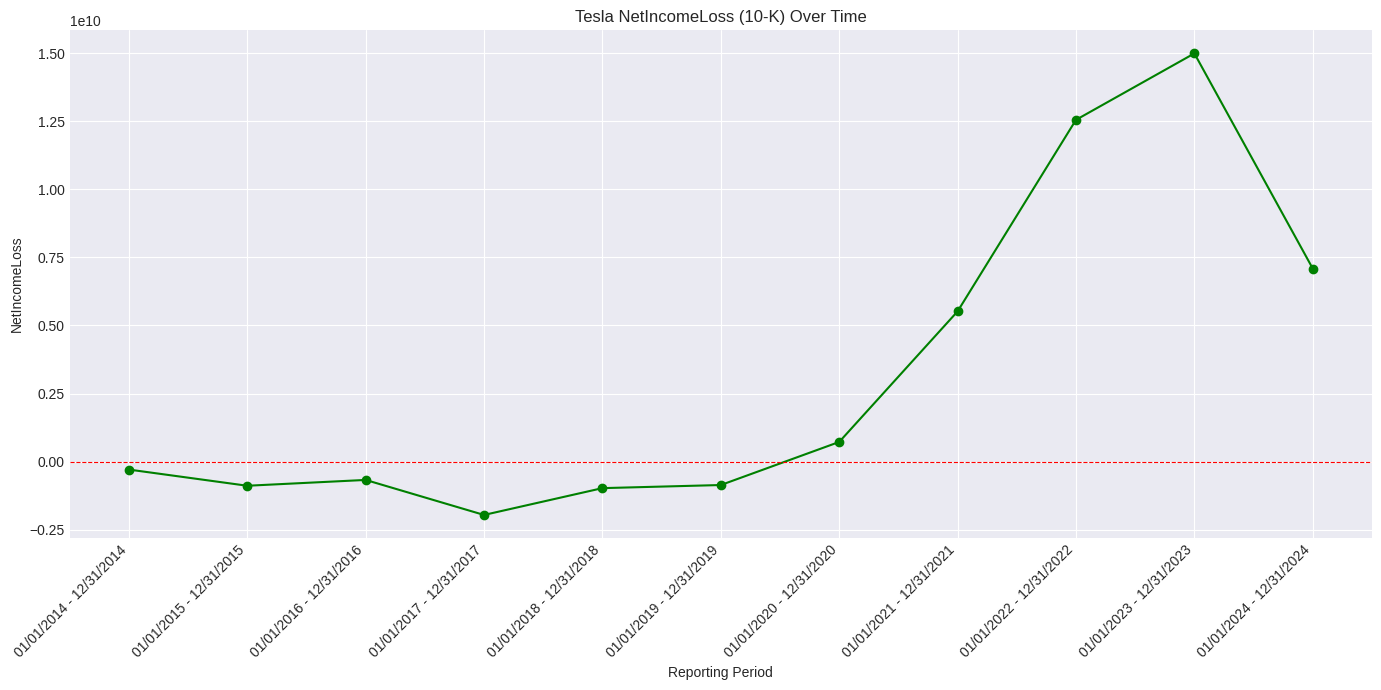

In [39]:
# Define possible column names for net income
net_income_column_names = ['NetIncomeLoss', 'ProfitLoss']
selected_net_income_column = None

# Check which column name is available in the DataFrame index
for col_name in net_income_column_names:
    if col_name in df_aggregated.index:
        selected_net_income_column = col_name
        break

# If appropriate column is found, create the chart
if selected_net_income_column:
    print(f"Selected column for net income: {selected_net_income_column}")

    # Prepare data for the chart
    net_income_data = df_aggregated.loc[selected_net_income_column]

    # Sort data by end date of the period
    periods = net_income_data.index
    try:
        # Adjust date format for parsing to m/d/y or m/d/Y
        sort_dates = []
        for p in periods:
            try:
                # Try parsing as m/d/y (two-digit year)
                end_date_str = p.split(' - ')[1]
                sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%y'))
            except ValueError:
                # If m/d/y doesn't work, try m/d/Y (four-digit year)
                try:
                     end_date_str = p.split(' - ')[1]
                     sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%Y'))
                except Exception as e:
                    print(f"Failed to parse date '{end_date_str}' in period '{p}'. Expected format m/d/y or m/d/Y. Error: {e}")
                    # You can decide what to do in case of parsing error, e.g., skip this entry
                    raise # Re-raise the exception to stop sorting if format is invalid

        sorted_indices = sorted(range(len(sort_dates)), key=lambda k: sort_dates[k])
        sorted_periods = [periods[i] for i in sorted_indices]
        sorted_net_income_values = [net_income_data[periods[i]] for i in sorted_indices]

    except Exception as e:
        print(f"An error occurred while sorting data for {selected_net_income_column}. Chart may not be chronological. Error: {e}")
        sorted_periods = periods
        sorted_net_income_values = net_income_data.values


    # Create line chart
    plt.figure(figsize=(14, 7))
    plt.plot(sorted_periods, sorted_net_income_values, marker='o', color='green')
    plt.title(f'Tesla {selected_net_income_column} (10-K) Over Time')
    plt.xlabel('Reporting Period')
    plt.ylabel(selected_net_income_column)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(True)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add line at 0
    plt.show()
else:
    print(f"None of the columns {net_income_column_names} were found in the aggregated data.")

5. Comparison of Tesla's Revenues and Cost of Revenue Over Time

This bar chart visualizes Tesla's financial performance by comparing two key metrics: Revenues and Cost of Revenue across different time periods. The blue bars represent Revenues, while the coral-colored bars show the Cost of Revenue. The chart includes a grid for better readability and is sorted chronologically to show the trend over time. This visualization helps in understanding the relationship between Tesla's income and the direct costs associated with generating that income.

Creating chart comparing Revenues and Cost of Revenue.


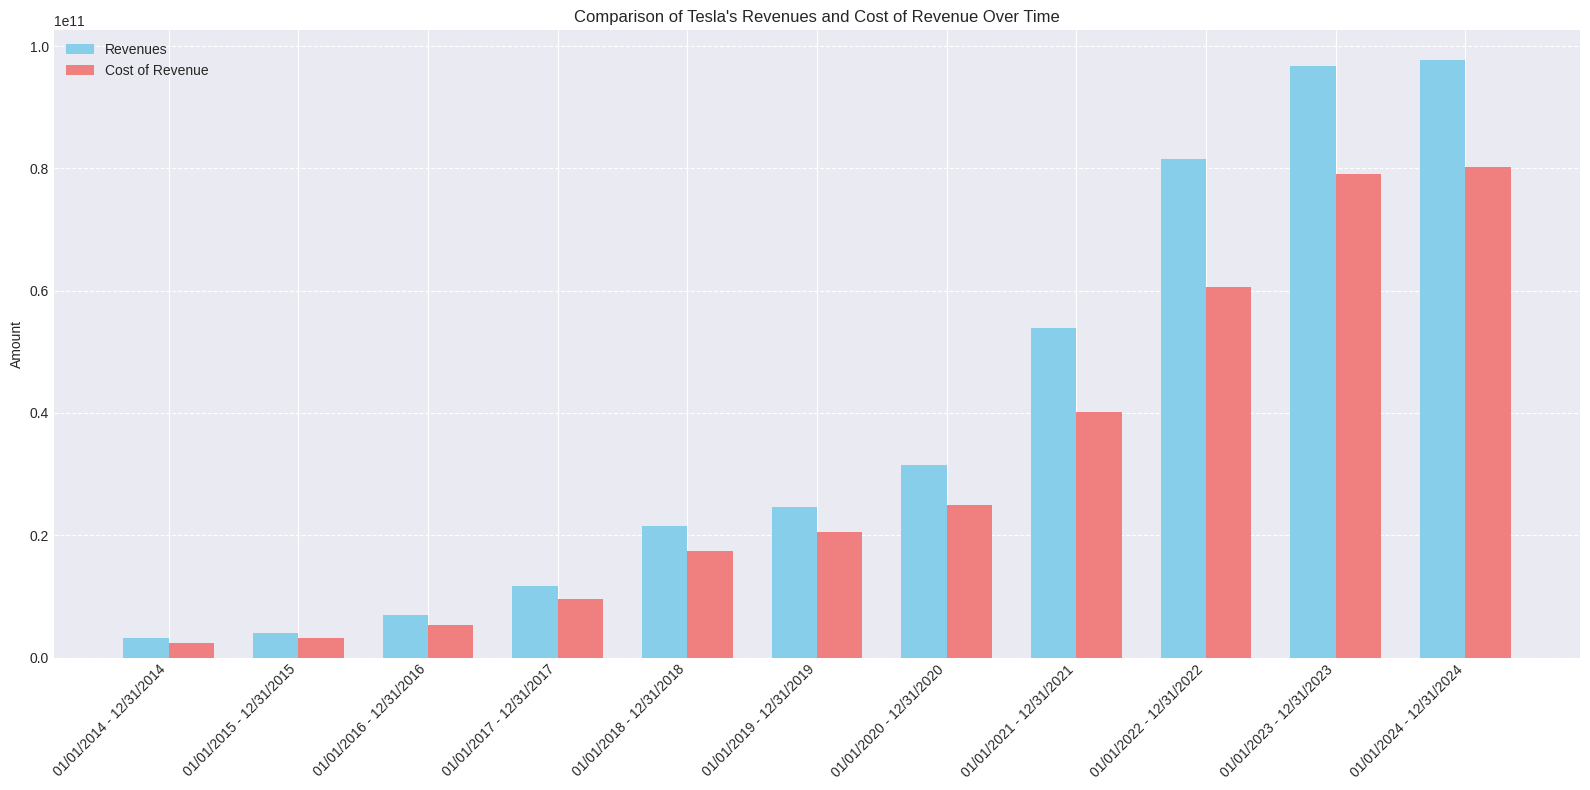

In [32]:
# Check if 'Revenues' and 'CostOfRevenue' are available
if 'Revenues' in df_aggregated.index and 'CostOfRevenue' in df_aggregated.index:
    print("Creating chart comparing Revenues and Cost of Revenue.")

    # Select data for Revenues and Cost of Revenue
    revenue_data = df_aggregated.loc['Revenues']
    cost_of_revenue_data = df_aggregated.loc['CostOfRevenue']

    # Ensure both series have the same periods and are sorted chronologically
    # We'll use the same end dates and sorting logic as before
    periods = revenue_data.index.intersection(cost_of_revenue_data.index) # Ensure periods are common
    revenue_data = revenue_data[periods]
    cost_of_revenue_data = cost_of_revenue_data[periods]

    try:
        # Sort data by period end date
        sort_dates = []
        for p in periods:
             try:
                # Try parsing as m/d/y (two-digit year)
                end_date_str = p.split(' - ')[1]
                sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%y'))
             except ValueError:
                # If m/d/y doesn't work, try m/d/Y (four-digit year)
                try:
                     end_date_str = p.split(' - ')[1]
                     sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%Y'))
                except Exception as e:
                    print(f"Failed to parse date '{end_date_str}' in period '{p}'. Expected format m/d/y or m/d/Y. Error: {e}")
                    raise # Re-raise the exception

        sorted_indices = sorted(range(len(sort_dates)), key=lambda k: sort_dates[k])
        sorted_periods = [periods[i] for i in sorted_indices]
        sorted_revenue_values = [revenue_data[periods[i]] for i in sorted_indices]
        sorted_cost_of_revenue_values = [cost_of_revenue_data[periods[i]] for i in sorted_indices]

    except Exception as e:
        print(f"Error occurred while sorting data for revenue and cost chart. Chart may not be chronological. Error: {e}")
        sorted_periods = periods
        sorted_revenue_values = revenue_data.values
        sorted_cost_of_revenue_values = cost_of_revenue_data.values

    # Chart settings
    x = range(len(sorted_periods)) # Bar positions on X axis
    width = 0.35 # Bar width

    plt.figure(figsize=(16, 8)) # Increased size for better readability

    # Creating bar chart
    plt.bar(x, sorted_revenue_values, width, label='Revenues', color='skyblue')
    plt.bar([i + width for i in x], sorted_cost_of_revenue_values, width, label='Cost of Revenue', color='lightcoral') # Cost bars next to revenue bars

    # Adding labels and title
    plt.ylabel('Amount')
    plt.title('Comparison of Tesla\'s Revenues and Cost of Revenue Over Time')
    plt.xticks([i + width/2 for i in x], sorted_periods, rotation=45, ha='right') # Setting X axis labels in the middle of bar pairs
    plt.legend()
    plt.grid(axis='y', linestyle='--') # Add horizontal grid lines
    plt.tight_layout()
    plt.show()

elif 'Revenues' not in df_aggregated.index:
    print("'Revenues' not found in aggregated data. Cannot create comparison chart.")
elif 'CostOfRevenue' not in df_aggregated.index:
     print("'CostOfRevenue' not found in aggregated data. Cannot create comparison chart.")
else:
    print("'Revenues' or 'CostOfRevenue' not found in aggregated data. Cannot create comparison chart.")

6. Tesla's Gross Margin vs Net Margin Over Time

This visualization presents a comparative analysis of Tesla's financial performance through two key profitability metrics: Gross Margin and Net Margin. The chart tracks these margins as percentages over different reporting periods, providing insights into Tesla's operational efficiency and overall profitability. The blue line represents the Gross Margin, which shows the profit after accounting for direct costs of goods sold, while the orange dashed line indicates the Net Margin, reflecting the final profitability after all expenses. The chart includes a reference line at 0% to easily identify periods of profit and loss. This analysis helps in understanding how Tesla's pricing strategy, cost management, and overall business efficiency have evolved over time.

Creating chart comparing gross margin and net margin.


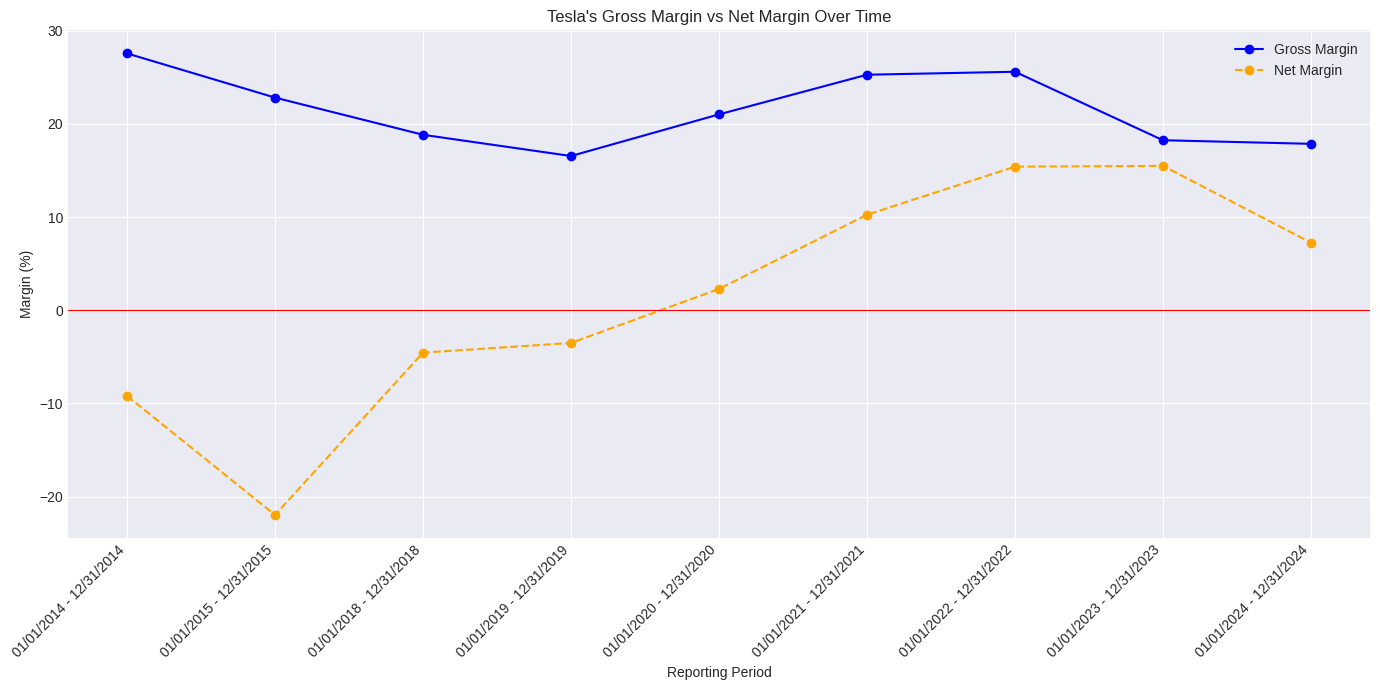

In [33]:
# Define possible column names for net income
net_income_column_names = ['NetIncomeLoss', 'ProfitLoss']
selected_net_income_column = None

# Check which net income column name is available
for col_name in net_income_column_names:
    if col_name in df_aggregated.index:
        selected_net_income_column = col_name
        break

# Check if required data is available
if 'Revenues' in df_aggregated.index and 'CostOfRevenue' in df_aggregated.index and selected_net_income_column:
    print("Creating chart comparing gross margin and net margin.")

    # Select data
    revenue_data = df_aggregated.loc['Revenues']
    cost_of_revenue_data = df_aggregated.loc['CostOfRevenue']
    net_income_data = df_aggregated.loc[selected_net_income_column]

    # Ensure all three series have the same periods and are chronologically sorted
    common_periods = revenue_data.index.intersection(cost_of_revenue_data.index).intersection(net_income_data.index)

    if len(common_periods) > 0: # Ensure there are common periods
        revenue_data = revenue_data[common_periods]
        cost_of_revenue_data = cost_of_revenue_data[common_periods]
        net_income_data = net_income_data[common_periods]

        try:
            # Sort data by end date of the period
            sort_dates = []
            for p in common_periods:
                 try:
                    # Try parsing as m/d/y (two-digit year)
                    end_date_str = p.split(' - ')[1]
                    sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%y'))
                 except ValueError:
                    # If m/d/y doesn't work, try m/d/Y (four-digit year)
                    try:
                         end_date_str = p.split(' - ')[1]
                         sort_dates.append(datetime.strptime(end_date_str, '%m/%d/%Y'))
                    except Exception as e:
                        print(f"Failed to parse date '{end_date_str}' in period '{p}'. Expected format m/d/y or m/d/Y. Error: {e}")
                        raise # Re-raise the exception

            sorted_indices = sorted(range(len(sort_dates)), key=lambda k: sort_dates[k])
            sorted_periods = [common_periods[i] for i in sorted_indices]

            # Sort data series according to sorted periods
            sorted_revenue_values = revenue_data.loc[sorted_periods]
            sorted_cost_of_revenue_values = cost_of_revenue_data.loc[sorted_periods]
            sorted_net_income_values = net_income_data.loc[sorted_periods]


        except Exception as e:
            print(f"Error occurred while sorting data for margin chart. Chart may not be chronological. Error: {e}")
            # If sorting failed, use original data but issue a warning
            sorted_periods = common_periods
            sorted_revenue_values = revenue_data
            sorted_cost_of_revenue_values = cost_of_revenue_data
            sorted_net_income_values = net_income_data


        # Calculate gross and net margin (ensure Revenues is not zero)
        gross_margin = ((sorted_revenue_values - sorted_cost_of_revenue_values) / sorted_revenue_values * 100).replace([float('inf'), float('-inf')], pd.NA).dropna()
        net_margin = (sorted_net_income_values / sorted_revenue_values * 100).replace([float('inf'), float('-inf')], pd.NA).dropna()

        # Ensure margins have the same index (periods)
        final_periods = gross_margin.index.intersection(net_margin.index)
        gross_margin = gross_margin[final_periods]
        net_margin = net_margin[final_periods]


        if len(final_periods) > 0:
            # Create line chart for margins
            plt.figure(figsize=(14, 7))

            plt.plot(final_periods, gross_margin.values, marker='o', label='Gross Margin', color='blue')
            plt.plot(final_periods, net_margin.values, marker='o', label='Net Margin', color='orange', linestyle='--') # Use different line style

            plt.title('Tesla\'s Gross Margin vs Net Margin Over Time')
            plt.xlabel('Reporting Period')
            plt.ylabel('Margin (%)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.grid(True)
            plt.axhline(0, color='red', linestyle='-', linewidth=0.8) # Add line at 0%
            plt.legend()
            plt.show()
        else:
             print("No common periods after margin calculation. Cannot create chart.")

    else:
         print("No common periods for Revenues, Cost of Revenue, and Net Income. Cannot create chart.")

elif 'Revenues' not in df_aggregated.index:
    print("'Revenues' not found in aggregated data. Cannot create margin chart.")
elif 'CostOfRevenue' not in df_aggregated.index:
     print("'CostOfRevenue' not found in aggregated data. Cannot create margin chart.")
elif not selected_net_income_column:
    print(f"None of the columns {net_income_column_names} for net income were found in aggregated data. Cannot create margin chart.")
else:
     print("Missing required data to create margin chart.")